# CLASSIFICATION

In [58]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
import os

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

In [9]:
def seed_everything(seed=42):
    """"Seed everything.
    """   
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [10]:
seed_everything()

In [73]:
def classification_metric(y_true, y_pred):
    labs = ["high_rain", "low_rain", "no_rain"]
    f1 = f1_score(y_true, y_pred, labels = labs, average = "weighted")
    class_recall = recall_score(y_true, y_pred, labels = labs, average = None)
    total_recall = recall_score(y_true, y_pred, labels = labs, average = "weighted")
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels = labs, average = None)

    table = pd.crosstab(y_pred, y_true)
    table["recall"] = class_recall
    table["precision"] = precision
    print("The confusion matrix ")
    print(table)
    print("The prediction accuracy: ", acc)
    print("The f1-score : ", f1)
    print("The recall-score : ", total_recall)


In [11]:
train_set = pd.read_csv("data/train_set.txt",sep = ' ')
test_set = pd.read_csv("data/test_set.txt",sep = ' ')

In [12]:
train_set

,ff,t,td,hu,dd,precip_log,ws_arome,p3031_arome,u10_arome,v10_arome,...,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
1,-0.086213,1.164777,0.910535,-0.798235,0.520054,-0.820399,-0.036595,0.529785,0.801953,0.400758,...,0,0,0,1,0,0,0,0,0,0
2,-0.215296,-1.471529,-1.661333,-0.454718,0.695888,0.078895,-0.257664,1.323143,0.556898,-0.888709,...,1,0,0,0,0,0,0,0,0,0
4,-1.468680,0.129100,-0.187510,-1.056853,0.129012,-0.820399,-1.317523,-0.827820,-0.605044,-0.693706,...,0,0,1,0,0,0,0,0,0,0
5,1.028401,-1.238485,-1.421240,-0.491033,1.022205,0.269433,0.464623,1.063498,1.186435,-0.717044,...,0,0,0,0,0,0,0,0,0,0
6,-1.465538,-1.273800,-1.288810,0.075769,-0.850480,-0.612447,-1.277939,-0.588190,-0.432199,0.107395,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,-1.530734,-0.516512,-0.138244,1.196123,-1.643351,-0.820399,-1.372398,-0.675518,-0.807684,-0.353231,...,0,0,0,0,0,0,0,0,1,0
727,-1.169931,1.010201,0.849969,-0.528329,-0.517151,-0.436627,-0.937395,-1.045143,-0.647040,-0.734017,...,0,0,0,0,0,1,0,0,0,0
728,0.070624,1.223185,0.604995,-1.875404,0.563203,-0.820399,-0.361343,0.433055,-0.257686,0.071419,...,0,0,1,0,0,0,0,0,0,0
729,-1.387512,1.472917,1.344347,-0.480237,-1.532241,-0.612447,-1.125196,-1.264025,-1.094799,0.101478,...,0,0,0,1,0,0,0,0,0,0


In [13]:
X_train = pd.DataFrame(train_set).copy()
del X_train['rain']
del X_train['rain_class']
del X_train['rain_log']

X_test = pd.DataFrame(test_set).copy()
del X_test['rain']
del X_test['rain_class']
del X_test['rain_log']

In [14]:
train_set['rain_class'] = train_set['rain_class'].astype("category")
test_set['rain_class'] = test_set['rain_class'].astype("category")

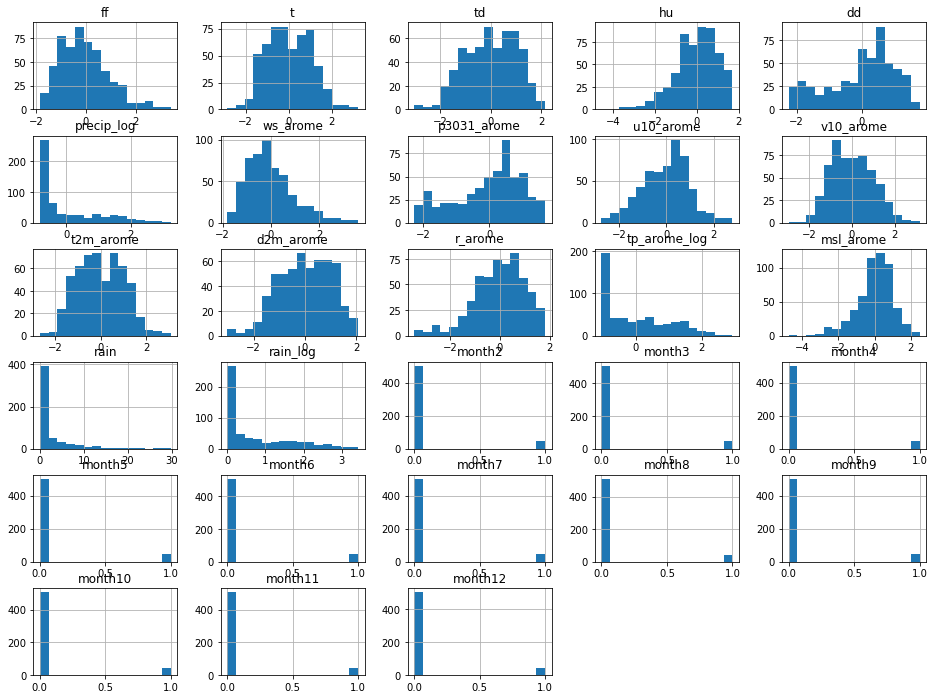

In [15]:
_ = train_set.hist(figsize=(16,12), bins = 15)

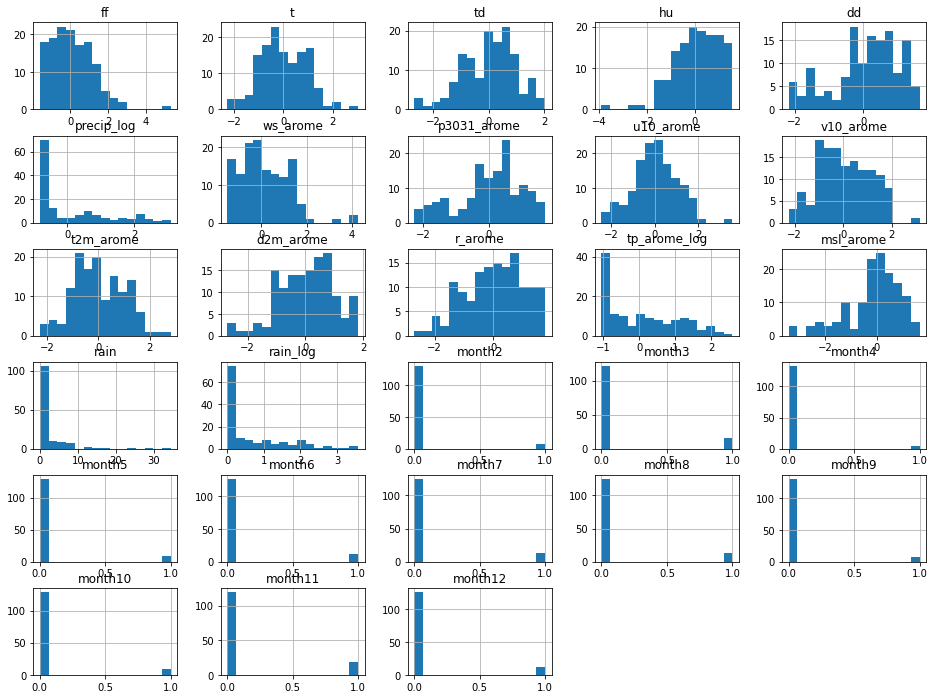

In [16]:
_ = test_set.hist(figsize=(16,12), bins = 15)

In [17]:
Y_train = train_set['rain']
Y_test = test_set['rain']

In [18]:
Y_train_class = train_set['rain_class']
Y_test_class = test_set['rain_class']


In [19]:
X_train.head()

,ff,t,td,hu,dd,precip_log,ws_arome,p3031_arome,u10_arome,v10_arome,...,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
1,-0.086213,1.164777,0.910535,-0.798235,0.520054,-0.820399,-0.036595,0.529785,0.801953,0.400758,...,0,0,0,1,0,0,0,0,0,0
2,-0.215296,-1.471529,-1.661333,-0.454718,0.695888,0.078895,-0.257664,1.323143,0.556898,-0.888709,...,1,0,0,0,0,0,0,0,0,0
4,-1.468680,0.129100,-0.187510,-1.056853,0.129012,-0.820399,-1.317523,-0.827820,-0.605044,-0.693706,...,0,0,1,0,0,0,0,0,0,0
5,1.028401,-1.238485,-1.421240,-0.491033,1.022205,0.269433,0.464623,1.063498,1.186435,-0.717044,...,0,0,0,0,0,0,0,0,0,0
6,-1.465538,-1.273800,-1.288810,0.075769,-0.850480,-0.612447,-1.277939,-0.588190,-0.432199,0.107395,...,0,0,0,0,0,0,0,0,0,1


## 1. K nearest neighbors

The completeness parameter `k` is optimised on a predefined grid by minimising the estimated error by cross-validation; scikit-learn offers many cross-validation options. 

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Optimisation of k
param_grid = [{"n_neighbors": list(range(1, 20))}]
knn = GridSearchCV(KNeighborsClassifier(weights = "distance"), scoring = "accuracy", param_grid = param_grid, cv=10, n_jobs=-1, refit = True)
knnOpt = knn.fit(X_train, Y_train_class)  
# optimal parameter
# knnOpt.best_params_["n_neighbors"]
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (knnOpt.best_score_, knnOpt.best_params_))

Best Mean cross-validated accuracy = 0.540000, Best parameter = {'n_neighbors': 18}


The prediction accuracy in the test set

In [21]:
# Estimation of the prediction accuracy on the test sample
print("Prediction accuracy in the test sample : ", knnOpt.score(X_test, Y_test_class))


Prediction accuracy in the test sample :  0.5072463768115942


In [74]:
# Prediction of the test sample
y_hat_class = knnOpt.predict(X_test)
classification_metric(Y_test_class, y_hat_class)
# print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_hat_class))

# # confusion matrix
# table = pd.crosstab(y_hat_class, Y_test_class)
# print("Confusion matrix")
# print(table)

The confusion matrix 
rain_class  high_rain  low_rain  no_rain    recall  precision
row_0                                                        
high_rain          20        11       11  0.606061   0.476190
low_rain           12        37       23  0.637931   0.513889
no_rain             1        10       13  0.276596   0.541667
The prediction accuracy:  0.5072463768115942
The f1-score :  0.49149747986245235
The recall-score :  0.5072463768115942


## 2. Decision tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
# Optimisation of shaft depth
param_grid = [{"max_depth": range(2,10), "min_samples_split" : range(2,10), "min_samples_leaf": range(1,5) }]
tree = GridSearchCV(DecisionTreeClassifier(max_features = 'auto', min_impurity_decrease = 1e-3, random_state = 42), scoring = "accuracy", param_grid = param_grid, cv=10, n_jobs=-1, refit = True)
treeOpt = tree.fit(X_train, Y_train_class)
# Optimal parameter
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (treeOpt.best_score_, treeOpt.best_params_))

Best Mean cross-validated accuracy = 0.512727, Best parameter = {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [24]:
# Estimation of the prediction error on the test sample
treeOpt.score(X_test, Y_test_class)

0.4855072463768116

In [75]:
# Prediction of the test sample
y_hat_class = treeOpt.predict(X_test)
classification_metric(Y_test_class, y_hat_class)

The confusion matrix 
rain_class  high_rain  low_rain  no_rain    recall  precision
row_0                                                        
high_rain          14         6        4  0.424242   0.583333
low_rain           17        39       29  0.672414   0.458824
no_rain             2        13       14  0.297872   0.482759
The prediction accuracy:  0.4855072463768116
The f1-score :  0.47219332917273416
The recall-score :  0.4855072463768116


    The `low_rain` class seems to be difficult to predict!

## 3. Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier 
# Parameters' definitions
forest = RandomForestClassifier(n_estimators = 500, 
   criterion='gini', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# Training
rfFit = forest.fit(X_train,Y_train_class)
# Out-of-bag error on the train sample
print(1 - rfFit.oob_score_)
# Out-of-bag error on the test sample
print(1 - rfFit.score(X_test,Y_test_class))

0.46545454545454545
0.5072463768115942


Hyper parameters tunning by cross validation

In [64]:
param = [{"n_estimators" : range(200, 500, 100) , "max_features": range(2,5), "max_depth" : range(10, 20, 2) }]
rf = GridSearchCV(RandomForestClassifier(random_state=42, criterion="entropy"),
        param, cv = 5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (rfOpt.best_score_, rfOpt.best_params_))

Best Mean cross-validated accuracy = 0.545455, Best parameter = {'max_depth': 12, 'max_features': 4, 'n_estimators': 300}


In [77]:
# Prediction of the test sample
y_pred_test = treeOpt.predict(X_test)
classification_metric(Y_test_class, y_pred_test)

The confusion matrix 
rain_class  high_rain  low_rain  no_rain    recall  precision
row_0                                                        
high_rain          14         6        4  0.424242   0.583333
low_rain           17        39       29  0.672414   0.458824
no_rain             2        13       14  0.297872   0.482759
The prediction accuracy:  0.4855072463768116
The f1-score :  0.47219332917273416
The recall-score :  0.4855072463768116


### Gradient Boosting applying to Random Forest

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [30]:
from xgboost import XGBRFClassifier

In [31]:
# define the model
model = XGBRFClassifier(n_estimators = 500, subsample = 0.99, random_state = 42, metric = "accuracy", n_jobs = -1)

In [32]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_train, Y_train_class, scoring='accuracy', cv = cv, n_jobs=-1)
# report performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.525 (0.052)


In [78]:
y_pred_test = model.predict(X_test)

classification_metric(Y_test_class, y_pred_test)

NotFittedError: need to call fit or load_model beforehand

## 4. Support Vector Machine

### 4.1. Linear SVM 

Optimisation of C - Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty

In [85]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
param=[{"C": np.linspace(0.01, 0.1, 10) }]
svm= GridSearchCV(LinearSVC(), param, cv=10, n_jobs = -1, scoring = "accuracy")
svmLinOpt=svm.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmLinOpt.best_score_,svmLinOpt.best_params_))

Best Mean cross-validated accuracy = 0.547273, Best parameter = {'C': 0.06000000000000001}


In [86]:
# Prediction of the test sample
y_pred_test = svmLinOpt.predict(X_test)
classification_metric(Y_test_class, y_pred_test)

The confusion matrix 
rain_class  high_rain  low_rain  no_rain    recall  precision
row_0                                                        
high_rain          25        11        9  0.757576   0.555556
low_rain            7        36       20  0.620690   0.571429
no_rain             1        11       18  0.382979   0.600000
The prediction accuracy:  0.572463768115942
The f1-score :  0.5626106436383117
The recall-score :  0.572463768115942


    It seems that with the linear kernel, the results is quite good comparing to other methods

### 4.2. SVM with polynomial kernels

By default, we take polynomial of degree 3

In [87]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param=[{"C":[0.1,0.4,0.5,0.6,0.8,1,1.2,1.4,1.6,2],"gamma":np.array(range(1,11))/100, "coef0":np.array(range(1,11))/10}]
svm= GridSearchCV(SVC(kernel="poly"),param,cv=10,n_jobs=-1,scoring = "accuracy")
svmPolyOpt=svm.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmPolyOpt.best_score_,svmPolyOpt.best_params_))

Best Mean cross-validated accuracy = 0.543636, Best parameter = {'C': 1, 'coef0': 0.9, 'gamma': 0.04}


In [ ]:
# Prediction of the test sample
y_hat_class = svmPolyOpt.predict(X_test)
print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_hat_class))
# confusion matrix
table = pd.crosstab(y_hat_class, Y_test_class)
print(table)

Accuracy score = 0.5217391304347826
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          20        10        7
low_rain           13        38       26
no_rain             0        10       14


Let's test for degree 2

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param=[{"C":[0.1,0.4,0.5,0.6,0.8,1,1.2,1.4,1.6,2],"gamma":np.array(range(1,11))/100, "coef0":np.array(range(1,11))/10}]
svm= GridSearchCV(SVC(kernel="poly",degree =2),param,cv=10,n_jobs=-1,scoring = "accuracy")
svmPoly2Opt=svm.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmPoly2Opt.best_score_,svmPoly2Opt.best_params_))

Best Mean cross-validated accuracy = 0.545455, Best parameter = {'C': 1, 'coef0': 0.9, 'gamma': 0.08}


In [ ]:
# Prediction of the test sample
y_hat_class = svmPoly2Opt.predict(X_test)
print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_hat_class))
# confusion matrix
table = pd.crosstab(y_hat_class, Y_test_class)
print(table)

Accuracy score = 0.5072463768115942
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          20        12        8
low_rain           12        34       23
no_rain             1        12       16


### 4.3. SVM with radial kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param=[{"C":[0.1,0.4,0.5,0.6,0.8,1,1.2,1.4,1.6,2],"gamma":np.array(range(1,11))/100, "coef0":np.array(range(1,11))/10}]
svm= GridSearchCV(SVC(kernel="rbf"),param,cv=10,n_jobs=-1,scoring = "accuracy")
svmRadOpt=svm.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmRadOpt.best_score_,svmRadOpt.best_params_))

Best Mean cross-validated accuracy = 0.567273, Best parameter = {'C': 1.2, 'coef0': 0.1, 'gamma': 0.1}


In [ ]:
# Prediction of the test sample
y_hat_class = svmRadOpt.predict(X_test)
print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_hat_class))
# confusion matrix
table = pd.crosstab(y_hat_class, Y_test_class)
print(table)

Accuracy score = 0.5217391304347826
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          21         9       10
low_rain           11        40       26
no_rain             1         9       11


### 4.3. SVM with sigmoid kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param=[{"C":[0.1,0.4,0.5,0.6,0.8,1,1.2,1.4,1.6,2],"gamma":np.array(range(1,11))/100, "coef0":np.array(range(1,11))/10}]
svm= GridSearchCV(SVC(kernel="sigmoid"),param,cv=10,n_jobs=-1,scoring = "accuracy")
svmSigOpt=svm.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (svmSigOpt.best_score_,svmSigOpt.best_params_))

Best Mean cross-validated accuracy = 0.516364, Best parameter = {'C': 0.4, 'coef0': 0.1, 'gamma': 0.05}


In [ ]:
# Prediction of the test sample
y_hat_class = svmSigOpt.predict(X_test)
print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_hat_class))
# confusion matrix
table = pd.crosstab(y_hat_class, Y_test_class)
print(table)

Accuracy score = 0.5217391304347826
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          26        12        8
low_rain            7        42       35
no_rain             0         4        4


# Neural Network

## Multi-layer Perceptron Classifier

In [35]:
from sklearn.neural_network import MLPClassifier

#### One hidden layer neural network

Firstly, we fit an one-hidden layer neural network with ReLU activation in the hidden layer and the softmax activation for the out put layer, and the log-loss function. We use here the default configuration for the optimisation task.

In [36]:
nnet1 = MLPClassifier(hidden_layer_sizes = (3), random_state = 42, max_iter = 1500)
nnet1.fit(X_train, Y_train_class)

MLPClassifier(hidden_layer_sizes=3, max_iter=1500, random_state=42)

In [37]:
nnet1.out_activation_

'softmax'

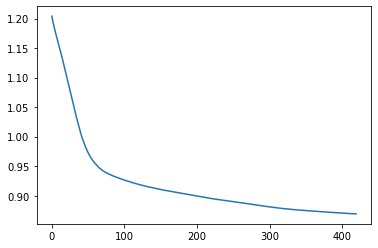

In [38]:
plt.plot(nnet1.loss_curve_)

In [39]:
y_pred_test = nnet1.predict(X_test)

print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_pred_test))
# confusion matrix
table = pd.crosstab(y_pred_test, Y_test_class)
print(table)

Accuracy score = 0.5144927536231884
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          24        10        8
low_rain            8        36       28
no_rain             1        12       11


We'll use cross validation for searching the optimal number of neurones in the hidden layer

In [ ]:
param_grid = [{"hidden_layer_sizes" : [(3,),(4,),(5,),(6,), (7,)], "early_stopping" : [True, False], "alpha" : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]}]

nnet1_cv = GridSearchCV(MLPClassifier(max_iter = 1500, random_state = 42), param_grid, cv = 5, n_jobs=-1, return_train_score = True)
nnet1_cv.fit(X_train, Y_train_class)

print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (nnet1_cv.best_score_, nnet1_cv.best_params_))

Best Mean cross-validated accuracy = 0.527273, Best parameter = {'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (5,)}


In [ ]:
nnet1Opt = nnet1_cv.best_estimator_

y_pred_test = nnet1Opt.predict(X_test)

print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_pred_test))
# confusion matrix
table = pd.crosstab(y_pred_test, Y_test_class)
print(table)

Accuracy score = 0.5289855072463768
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          25        12        8
low_rain            7        33       24
no_rain             1        13       15


Text(0.5, 0, 'Iteration')

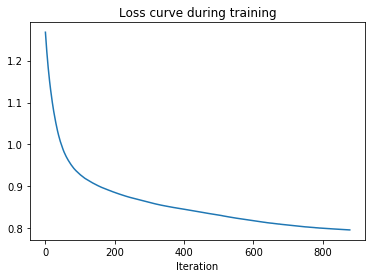

In [ ]:
plt.plot(nnet1Opt.loss_curve_)
plt.title("Loss curve during training")
plt.xlabel("Iteration")

We can see that the loss function is almost reached the minimum but the prediction accuracy is still arounded $50$ percents. It means that this model does not fit well the data. We will try with more sophisticated models in the next sections

### Multilayers Neural Network

In [ ]:
nnet = MLPClassifier(hidden_layer_sizes = (20, 12 , 10, 5), random_state = 42, max_iter = 1500, alpha = 0.1, activation = "relu", early_stopping = True, n_iter_no_change = 75)
nnet.fit(X_train, Y_train_class)


MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(20, 12, 10, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=75, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Training accuracy :  0.5509090909090909


Text(0.5, 0, 'Iteration')

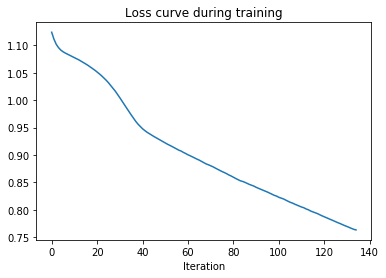

In [ ]:
print("Training accuracy : ", nnet.score(X_train, Y_train_class))
plt.plot(nnet.loss_curve_)
plt.title("Loss curve during training")
plt.xlabel("Iteration")

In [ ]:
y_pred_test = nnet.predict(X_test)

print("Prediction accuracy in test set =", accuracy_score(y_true = Y_test_class, y_pred = y_pred_test))
# confusion matrix
table = pd.crosstab(y_pred_test, Y_test_class)
print(table)

Prediction accuracy in test set = 0.5289855072463768
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          23        11       10
low_rain            9        44       31
no_rain             1         3        6


# Gaussian Process Classification

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern


In [ ]:
GPC = GaussianProcessClassifier(kernel = 0.5*RBF(3.0), random_state = 42, multi_class = "one_vs_rest")
GPC.fit(X_train, Y_train_class)
print(GPC.score(X_train, Y_train_class))
print(GPC.score(X_test, Y_test_class))

0.5981818181818181
0.5144927536231884


In [ ]:
GPC = GaussianProcessClassifier(kernel = Matern(3.0, nu = 1.5), random_state = 42, multi_class = "one_vs_rest")
GPC.fit(X_train, Y_train_class)
print(GPC.score(X_train, Y_train_class))
print(GPC.score(X_test, Y_test_class))

0.6218181818181818
0.5217391304347826
